<h1>Installation and Setup</h1>
This is where all installations of third party libraries to require us the dependencies we need.



<h1> Imports</h1>
The following tools are what we need to use in order to check the nature of the data under the CoNLL Dataset we downloaded above.

<h4>Process</h4>
WE define the process based on the features and goals we would like to extract from the Data. The followin visualizations are our goal:

*   Identifying the sentence length based on the segmented text
*   Identifying the Skewness of each token that are under PHI terms mentioned before and
*   Identifying how the grammatical structure affects the labeled PHI term meaning in a sentence, contextual and token level.



In [2]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="white", context="talk")
plt.style.use('default')
%matplotlib inline

In [1]:
import os
import re
import gc
import sys
import random
import datetime
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict, namedtuple, Counter

from typing import (List, Dict, Any, Tuple, Optional, Union)

In [3]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

## Dataset Summary
The shared task of **I2B2 2014** concerns language-independent named entity recognition. 

There are 8 types of named entities: 
*  DATE, 
*  NAME, 
*  LOCATION, 
*  AGE, 
*  ID, 
*  PROFESSION, 
*  CONTACT, 
*  PHI

The I2B2-2014 task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. 

#### Columns:
1. **Token** - a single word,
2. **NERTag** - the named entity tag

#### Other notes:
* Dataset uses **IOB1 tagging scheme**, where the `I- prefix` before a tag indicates that the tag is inside a chunk. An `O tag` indicates that a token belongs to no chunk. The `B- prefix` before a tag indicates that the tag is the beginning of a chunk that immediately follows another chunk without O tags between them. It is used only in that case: when a chunk comes after an O tag, the first token of the chunk takes the I- prefix. 
* `-DOCSTART-` - is a special line that acts as a boundary between two different documents.



In [4]:
train_fn = "/content/train.txt"
val_fn = "/content/test.txt"

In [5]:
class TextData:
    """ Representation of single sentence/text and it's attributes. """

    def __init__(self, tokens: List[str], 
                 ner_tags: List[str]) -> None:
        self.tokens = tokens
        self.ner_tags = ner_tags
        self.spans = None
    
    def __str__(self) -> str:
        s = f"Tokens: {self.tokens},\n"
        s += f"NER tags: {self.ner_tags},\n"
        return s
    
    def set_spans(self, spans: List[List[int]]):
        """
        Initialize spans bondaries in the tokens sequence.
        Spans are `inclusive`.
        e.t. [start_i, end_i], not (start_i, end_i) !
        """
        self.spans = spans

In [6]:
def split_tag(span_tag: str):
    """
    Split span tag into IOBES prefix and chunk_type
    e.g. 
    B-PER -> (B, PER)
    O -> (O, None)
    """
    if span_tag == 'O':
        return ('O', None)
    return span_tag.split('-', maxsplit=1)

def _is_doc_start(line: str) -> bool:
    if line.strip().startswith("-DOCSTART-"):
        return True
    return False

def _is_divider(line: str) -> bool:
    empty_line = line.strip() == ''
    if empty_line:
        return True
    return False

def read_conllu_data(data_fn: str):
    dataset = []

    with open(str(data_fn), 'rt') as f:
        for is_divider, lines in itertools.groupby(f, _is_divider):
            lines = list(lines)
            if is_divider or not len(lines[0]):
                continue
            if _is_doc_start(lines[0]):
                continue
            # fields of data
            fields = [line.strip().split() for line in lines]
            # data as list: [[tokens], [pos_tags], [sync_tags], [ner_tags]]
            fields = [list(field) for field in zip(*fields)]  
            dataset.append(TextData(tokens=fields[0],
                                    ner_tags=fields[1]))
    return dataset

In [7]:
train_data = read_conllu_data(str(train_fn))
test_data = read_conllu_data(str(val_fn))

print(f"Train data contains: {len(train_data)} texts and total {sum([len(d.tokens) for d in train_data])} tokens")
print(f"Val data contains: {len(test_data)} texts and total {sum([len(d.tokens) for d in test_data])} tokens")

Train data contains: 22340 texts and total 412443 tokens
Val data contains: 11100 texts and total 195170 tokens


In [11]:
train_sentences_lens = [len(sent.tokens) for sent in train_data]
test_sentences_lens = [len(sent.tokens) for sent in test_data]

<h2>Comparison Of Sentence Lengths</h2>
As stated before, we will compare the  mean of the sentence lengths of the dataset.

Train Dataset sentences length distributions:
count    22340.000000
mean        18.462086
std         33.407522
min          1.000000
25%          6.000000
50%         11.000000
75%         19.000000
max        923.000000
dtype: float64


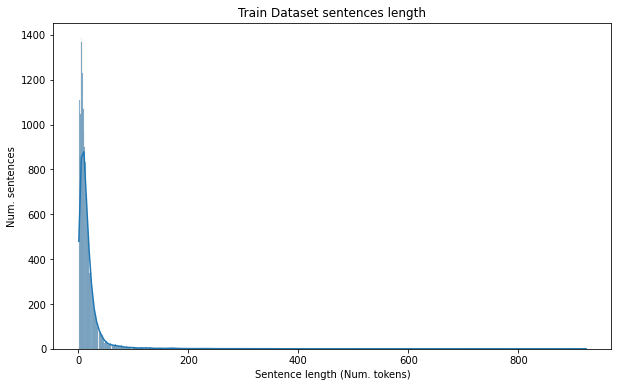

In [12]:
# Training Data
plt.figure(figsize=(10, 6))
d = sns.histplot(data=train_sentences_lens, kde=True)
d.set_ylabel("Num. sentences")
d.set_xlabel("Sentence length (Num. tokens)")
_ = d.set_title("Train Dataset sentences length")\

print(f"Train Dataset sentences length distributions:")
print(pd.Series(train_sentences_lens).describe())

Test Dataset sentences length distributions:
count    11100.000000
mean        17.582883
std         31.194481
min          1.000000
25%          6.000000
50%         11.000000
75%         19.000000
max        656.000000
dtype: float64


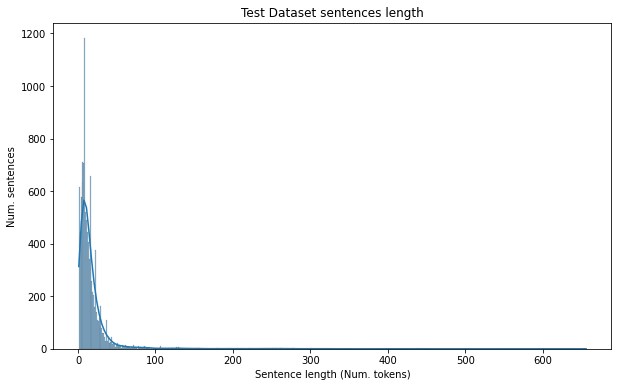

In [13]:
# On validation data
plt.figure(figsize=(10, 6))
d = sns.histplot(data=test_sentences_lens, kde=True)
d.set_ylabel("Num. sentences")
d.set_xlabel("Sentence length (Num. tokens)")
_ = d.set_title("Test Dataset sentences length")\

print(f"Test Dataset sentences length distributions:")
print(pd.Series(test_sentences_lens).describe())

**Findings**


*   Validation dataset's sentences are a bit more longer than the sentences in the training data at mean value. However this point is not very critical, cause difference is not very high: 18.4 vs. 17.5


<h2>Tag Distribution: </h2>
Checking the Tag Distribution given the NER-tags in the dataset

In [14]:
def ner_tags_distribution(text_data: List[TextData]) -> Dict[str, Any]:
    return Counter(list(itertools.chain.from_iterable([text.ner_tags for text in text_data]))).most_common()

def ner_tags_distribution_splitted(text_data: List[TextData]) -> Dict[str, Any]:
    tags_ = [split_tag(tag) for text in text_data for tag in text.ner_tags]
    return Counter([tag[0] if tag[1] is None else tag[1] for tag in tags_ ]).most_common()

In [16]:
# Calculate separately

# Tags with prefixes: B- and I-
train_ner_tags_dist = pd.DataFrame.from_records(ner_tags_distribution(train_data), 
                                                columns=['tag', 'cnt'])
test_ner_tags_dist = pd.DataFrame.from_records(ner_tags_distribution(test_data), 
                                              columns=['tag', 'cnt'])
# Tags without prefixes
train_ner_tags_spl_dist = pd.DataFrame.from_records(ner_tags_distribution_splitted(train_data), 
                                                columns=['tag', 'cnt'])
test_ner_tags_spl_dist = pd.DataFrame.from_records(ner_tags_distribution_splitted(test_data), 
                                              columns=['tag', 'cnt'])

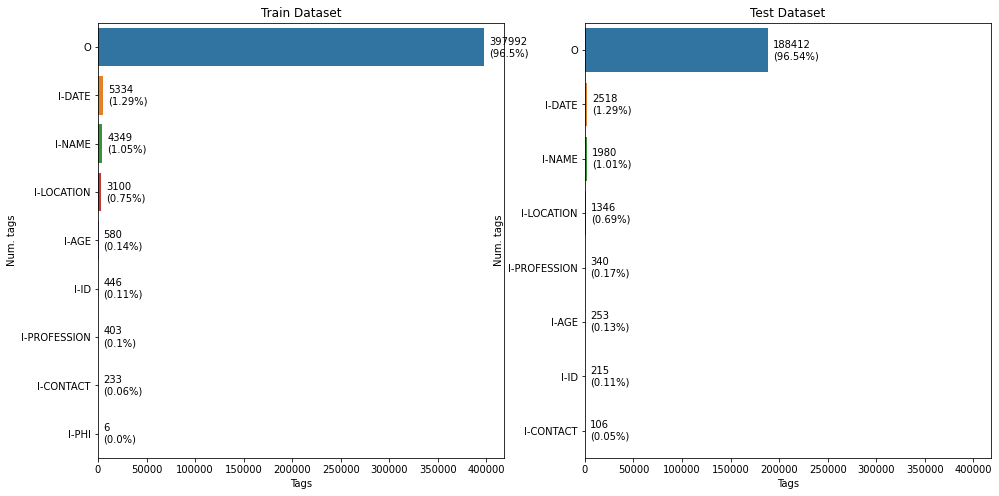

In [17]:
# Visualize with prefixes
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 8))

axes[0].set_title('Train Dataset')
sns.barplot(data=train_ner_tags_dist, y="tag", x='cnt', ax=axes[0])
axes[0].set_ylabel("Num. tags")
axes[0].set_xlabel("Tags")

sum_train_tags = sum([p.get_width() for p in axes[0].patches])
for p in axes[0].patches:
    axes[0].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_train_tags), 2)}%)",
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

axes[1].set_title('Test Dataset')
sns.barplot(data=test_ner_tags_dist, y="tag", x='cnt', ax=axes[1])
axes[1].set_ylabel("Num. tags")
axes[1].set_xlabel("Tags")

sum_val_tags = sum([p.get_width() for p in axes[1].patches])
for p in axes[1].patches:
    axes[1].annotate(f"{int(p.get_width())}\n({round(100*(p.get_width()/sum_val_tags), 2)}%)", 
                     xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")

plt.show()

In [19]:
ner_tags_dist = train_ner_tags_spl_dist.merge(test_ner_tags_spl_dist, 
                                              how='outer', on='tag', 
                                              suffixes=['_train', '_val']).fillna(0)
ner_tags_dist['cnt'] = (ner_tags_dist['cnt_train'] + ner_tags_dist['cnt_val']).astype('int')
entities_types = ner_tags_dist['tag'].unique().tolist()
print(f"No-prefixes entities types: {entities_types}")

ner_tags_dist = train_ner_tags_dist.merge(test_ner_tags_dist, 
                                          how='outer', on='tag', 
                                          suffixes=['_train', '_val']).fillna(0)
ner_tags_dist['cnt'] = (ner_tags_dist['cnt_train'] + ner_tags_dist['cnt_val']).astype('int')
pref_entities_types = ner_tags_dist['tag'].unique().tolist()
print(f"With-prefixes entities types: {pref_entities_types}")

No-prefixes entities types: ['O', 'DATE', 'NAME', 'LOCATION', 'AGE', 'ID', 'PROFESSION', 'CONTACT', 'PHI']
With-prefixes entities types: ['O', 'I-DATE', 'I-NAME', 'I-LOCATION', 'I-AGE', 'I-ID', 'I-PROFESSION', 'I-CONTACT', 'I-PHI']


**Findings**

*   There is **a strong imbalance of classes**, and it does not make sense to take into account the OUT label at all in quality estimation of the model.
*   Another option is to augment our training dataset with new samples for NE classes: ``` [`PER`, `ORG`, `LOC`, `MISK`] ```

#### Spans of Named Entities

Named Entities  in texts are usually represented as contiguous spans of tokens, so let's discover **lengths distribution** of them and **average number of spans** in each sentence.

Let's select them and print some examples of them: 

In [20]:
n_examples = 5
entities_examples = dict.fromkeys([t for t in entities_types if t != "O"])

for ent_name in [t for t in entities_types if t != "O"]:
    n_found = 0
    found_spans = []
    for d in train_data:
        if ent_name in np.unique([tag.split("-")[-1] for tag in d.ner_tags]):
            span_tokens = []
            start_i = d.ner_tags.index(f"I-{ent_name}")  # for IOB1 tagging
            for i, tag in enumerate(d.ner_tags[start_i:]):
                if tag in ["O", "B"]:  # for IOB1 tagging
                    break
                span_tokens.append(d.tokens[start_i+i])
            found_spans.append(" ".join(span_tokens))
            n_found += 1
            if n_found > n_examples:
                break
    entities_examples[ent_name] = found_spans

for ent, exs in entities_examples.items():
    print(f"{ent}:")
    for e in exs:
        print(f"\t{e}")

DATE:
	2067-05-03
	4/5/67
	7/67
	2062
	4/63
	3/67
NAME:
	Oakley 4/5/67
	Oakley
	Oakley
	Oakley
	Dolan
	Dolan
LOCATION:
	Clarkfield
	Clarkfield 3/67
	Clarkfield 3/67
	Convergys
	Clarkfield 3/67
	Convergys
AGE:
	55
	37
	37
	37
	78
	26
ID:
	pf 0760305
	6381987
	425-03-15-1
	IL050/525 IKECHUKWU SPEARS
	425-03-15-1
	OT109/6637 FRANK EMMONS
PROFESSION:
	Sculptor
	Sculptor
	Sculptor
	Economist
	economics
	Carpentry Supervisor
CONTACT:
	69981
	170-574-2276
	78686
	50173
	82910
	82910
PHI:
	October
	February 2086
	October
	2073
	Yehuda Landers


In [21]:
def select_spans_IOB1(text_data: List[TextData]) -> List[List[int]]:
    all_spans = []
    
    # iterate over the texts
    for d in text_data:
        spans = []
        cur_tag = None
        cur_start = None
        # iterate over the tags
        for tag_i, tag in enumerate(d.ner_tags):
            tag_pos = tag[0]  # tag `position`
            if tag_pos == 'B':
                # save previous span, if exists
                if cur_tag is not None:
                    spans.append([cur_tag, cur_start, tag_i - 1])
                cur_start = tag_i  # new tag starts
                cur_tag = tag[2:]  # tag `name`
            elif tag_pos == 'I':
                # new tag starts
                if cur_tag is None: 
                    cur_start = tag_i  # new tag starts
                    cur_tag = tag[2:]  # tag `name`
            elif tag_pos == 'O':
                # span finished, saving
                if cur_tag is not None:
                    spans.append([cur_tag, cur_start, tag_i - 1])
                    cur_tag = None
                    cur_start = None
        # save last span    
        if cur_tag is not None:
            spans.append([cur_tag, cur_start, tag_i + 1])

        # set to current sequence excluding tag type
        # d.set_spans([s[1:] for s in spans])
        all_spans.append(spans)

    return all_spans

def span_length(start_i: int, end_i: int) -> int:
    """ 
    Assumes inclusive span bondaries. 
    """
    return end_i - start_i + 1

In [26]:
# Retrieve spans of NE from train and val datasets
train_spans = select_spans_IOB1(train_data)
test_spans = select_spans_IOB1(test_data)

print(f"Train data contains: {sum([len(s) for s in train_spans])} NE spans.")
print(f"Test data contains: {sum([len(s) for s in test_spans])} NE spans.")

Train data contains: 10505 NE spans.
Test data contains: 4915 NE spans.


In [27]:
# Train spans
train_spans = pd.DataFrame.from_records(list(itertools.chain.from_iterable(train_spans)), 
                                        columns=['tag', 'start_i', 'end_i'])
train_spans['span_len'] = train_spans[['start_i', 'end_i']].apply(lambda x: span_length(x[0], x[1]), axis=1)

print("General span length distribution:")
print(train_spans['span_len'].describe())

print("\nBy Tags:")
train_spans.groupby(by='tag')['span_len'].describe()

General span length distribution:
count    10505.000000
mean         1.392765
std          0.894441
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         11.000000
Name: span_len, dtype: float64

By Tags:


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
AGE,557.0,1.016158,0.126196,1.0,1.0,1.0,1.0,2.0
CONTACT,210.0,1.680952,0.750196,1.0,1.0,2.0,2.0,6.0
DATE,4874.0,1.161059,0.632029,1.0,1.0,1.0,1.0,11.0
ID,341.0,1.325513,0.780023,1.0,1.0,1.0,1.0,5.0
LOCATION,1417.0,2.019054,1.516036,1.0,1.0,1.0,3.0,10.0
NAME,2816.0,1.539418,0.774281,1.0,1.0,1.0,2.0,9.0
PHI,4.0,1.500000,0.577350,1.0,1.0,1.5,2.0,2.0
PROFESSION,286.0,1.395105,0.846775,1.0,1.0,1.0,1.0,6.0


In [28]:
test_spans = pd.DataFrame.from_records(list(itertools.chain.from_iterable(test_spans)), 
                                        columns=['tag', 'start_i', 'end_i'])
test_spans['span_len'] = test_spans[['start_i', 'end_i']].apply(lambda x: span_length(x[0], x[1]), axis=1)

print("General span length distribution:")
print(test_spans['span_len'].describe())

print("\nBy Tags:")
test_spans.groupby(by='tag')['span_len'].describe()

General span length distribution:
count    4915.000000
mean        1.391658
std         0.871595
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: span_len, dtype: float64

By Tags:


,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
AGE,247.0,1.004049,0.063628,1.0,1.0,1.0,1.0,2.0
CONTACT,96.0,1.625000,0.714511,1.0,1.0,2.0,2.0,5.0
DATE,2318.0,1.183348,0.728920,1.0,1.0,1.0,1.0,10.0
ID,149.0,1.630872,1.187485,1.0,1.0,1.0,2.0,10.0
LOCATION,608.0,1.912829,1.330407,1.0,1.0,1.0,3.0,9.0
NAME,1252.0,1.562300,0.722008,1.0,1.0,1.0,2.0,6.0
PROFESSION,245.0,1.351020,0.819367,1.0,1.0,1.0,1.0,5.0


**Findings**

*   The longest Named Entities are (as quite expected) are referring to names and surnames - `PER` tag.
*   Anyway, entities are on average less than 2 tokens, which means that they are mostly simple and do not contain nested Named Entities.